In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 11:18:32.592525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 11:18:33.971553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 2150
end_idx = 2395
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(245, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(245, 96, 7)
(164640,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(245, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(245, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 11:18:42.153078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:88:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 11:18:44.692641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


8/8 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step
CPU time: 4511.320053324802 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

8/8 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.0074237  0.04621382 0.76035581 ... 0.28717391 0.29029732 0.58685818]
Fitness value of the best solution = 0.0019131777286607175


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

8/8 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


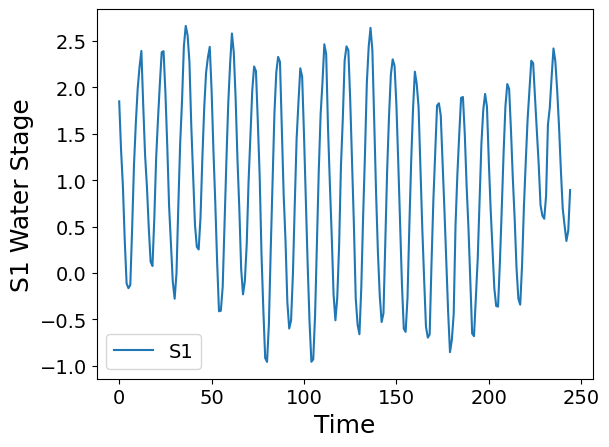

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low3.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.007424,0.046214,0.760356,0.216705,0.742851,0.192951,0.432042,0.220617,0.990786,0.646380,...,0.786205,0.713423,0.588103,0.114094,0.750130,0.393136,0.191987,0.003865,0.842030,0.018758
1,0.752523,0.409177,0.721154,0.609551,0.200996,0.658925,0.927211,0.051467,0.839195,0.829524,...,0.592286,0.895883,0.151881,0.052340,0.937345,0.319685,0.251540,0.605760,0.624622,0.965777
2,0.774109,0.506038,0.566339,0.844270,0.516396,0.385229,0.518595,0.016539,0.838911,0.841407,...,0.333920,0.197822,0.689425,0.707251,0.350921,0.779531,0.153891,0.883162,0.106063,0.024584
3,0.341772,0.335894,0.069466,0.591965,0.930532,0.322777,0.114701,0.121863,0.596279,0.823321,...,0.042684,0.621696,0.979322,0.622904,0.240091,0.271373,0.638648,0.012987,0.864154,0.898698
4,0.187986,0.496270,0.777091,0.026630,0.788315,0.221670,0.438930,0.009929,0.037452,0.220106,...,0.201317,0.171438,0.977115,0.581830,0.014285,0.760518,0.832559,0.220455,0.659603,0.346032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.529943,0.175199,0.344774,0.472836,0.649561,0.972269,0.333539,0.104520,0.870148,0.363097,...,0.986404,0.354738,0.591356,0.691338,0.103219,0.133875,0.301802,0.211230,0.234421,0.428464
241,0.886912,0.267917,0.967760,0.737135,0.109094,0.851310,0.267920,0.499412,0.158179,0.087428,...,0.911320,0.145169,0.266045,0.324808,0.417792,0.930301,0.063319,0.556412,0.416490,0.888351
242,0.964049,0.187865,0.931897,0.027792,0.469533,0.475698,0.222576,0.208554,0.364715,0.401218,...,0.333654,0.976766,0.513310,0.739033,0.060093,0.665261,0.024880,0.059898,0.826930,0.474836
243,0.369125,0.191093,0.172137,0.848044,0.082313,0.537204,0.753628,0.672157,0.205471,0.453917,...,0.084387,0.730391,0.757473,0.751941,0.233519,0.191923,0.692943,0.604694,0.396615,0.388665


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low3.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.848254,1.747451,1.874791,1.866628,1.415024,1.385869,1.396405,1.399902,0.926051,0.827529,...,1.449477,1.561135,1.979503,2.032047,1.937356,2.089067,2.196312,2.120065,2.175940,2.299984
1,1.328261,1.481253,1.391112,1.334053,0.899563,1.029632,0.948549,0.912605,0.299390,0.205136,...,1.882914,1.976993,2.264518,2.500267,2.297442,2.360068,2.352932,2.316782,2.377140,2.480042
2,0.936424,0.886754,1.074375,0.950067,0.292788,0.121572,0.414688,0.286950,-0.082320,0.038403,...,2.216618,2.296044,2.239285,2.429199,2.266745,2.315097,1.905889,2.120055,1.952535,2.013552
3,0.353041,0.388793,0.528324,0.388010,-0.052907,0.168716,0.065931,-0.072089,-0.238472,-0.241956,...,2.091511,2.196876,1.938820,2.013515,1.955317,2.059782,1.319740,1.537663,1.388275,1.454113
4,-0.111913,-0.375643,-0.013362,-0.137049,-0.283735,-0.200521,-0.276647,-0.321879,-0.102570,-0.298183,...,1.890947,2.013801,1.422417,1.507774,1.535847,1.492084,0.940582,1.017399,1.059230,1.007665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.694954,0.647473,0.802353,0.870301,0.410845,0.643672,0.468892,0.526451,0.339312,0.466116,...,1.992538,2.112183,1.677767,1.478997,1.700840,1.785977,1.212553,1.374675,1.191425,1.250644
241,0.513212,0.717250,0.599947,0.555990,0.395648,0.533146,0.523701,0.441774,0.486802,0.590071,...,1.764293,1.806329,1.295157,1.535614,1.311979,1.356009,0.869704,0.948314,1.047609,1.013466
242,0.345215,0.530969,0.548375,0.419947,0.470550,0.573698,0.514894,0.509585,0.895932,1.124549,...,1.443285,1.449558,0.863874,1.045289,1.016303,0.973695,0.316777,0.471322,0.477701,0.475521
243,0.456666,0.453354,0.618303,0.514587,0.865848,0.797708,0.898528,0.892505,1.326639,1.161477,...,0.901670,0.972104,0.421364,0.552134,0.604368,0.661698,0.041806,0.298821,0.246802,0.280273


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 4005, areas: 1285.383498039795


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

8/8 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 5319, areas: 2563.0374131709395
